In [1]:
import pickle
import os
import lc_model as model
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import parallel_simulation as sim

In [ ]:
# Parameters for the simulation
epoch = 960.0
sampling_rate = 1
num_simulations = 100000  # Adjust the number of simulations if needed
batch_size = 50  # Batch size for saving
VarDict = {
    "PSD_slope_fast": "fast_a1", "PSD_break_fast": "fast_b1",
    "mu_fast": "fast_mu", "sig_fast": "fast_sig", "PSD_slope_slow": "a1", "PSD_break_slow": "b1",
    "mu_slow": "mu", "sig_slow": "sig", "B_0": "B_0", "gamma": "gamma", "ampfac": "ampfac",
    "size_0": "size_0", "noise_NIR": "vlt_noise", "X_offset": "I_offset", "rate_conv": "rate_conv",
    "eff_area": "I_eff_area", "model_gain": "a", "f0_B": "f_0_B", "f0_theta": "f_0_size",
    "noise_345GHz": "APEX_noise", "noise_230GHz": "SMA_noise", "noise_340GHz": "APEX_noise"
}

# Run the parallel simulations with 4 workers
num_workers = 4
sim.Simulation.run_parallel_simulations(epoch, sampling_rate, VarDict, num_simulations, batch_size, num_workers)

600


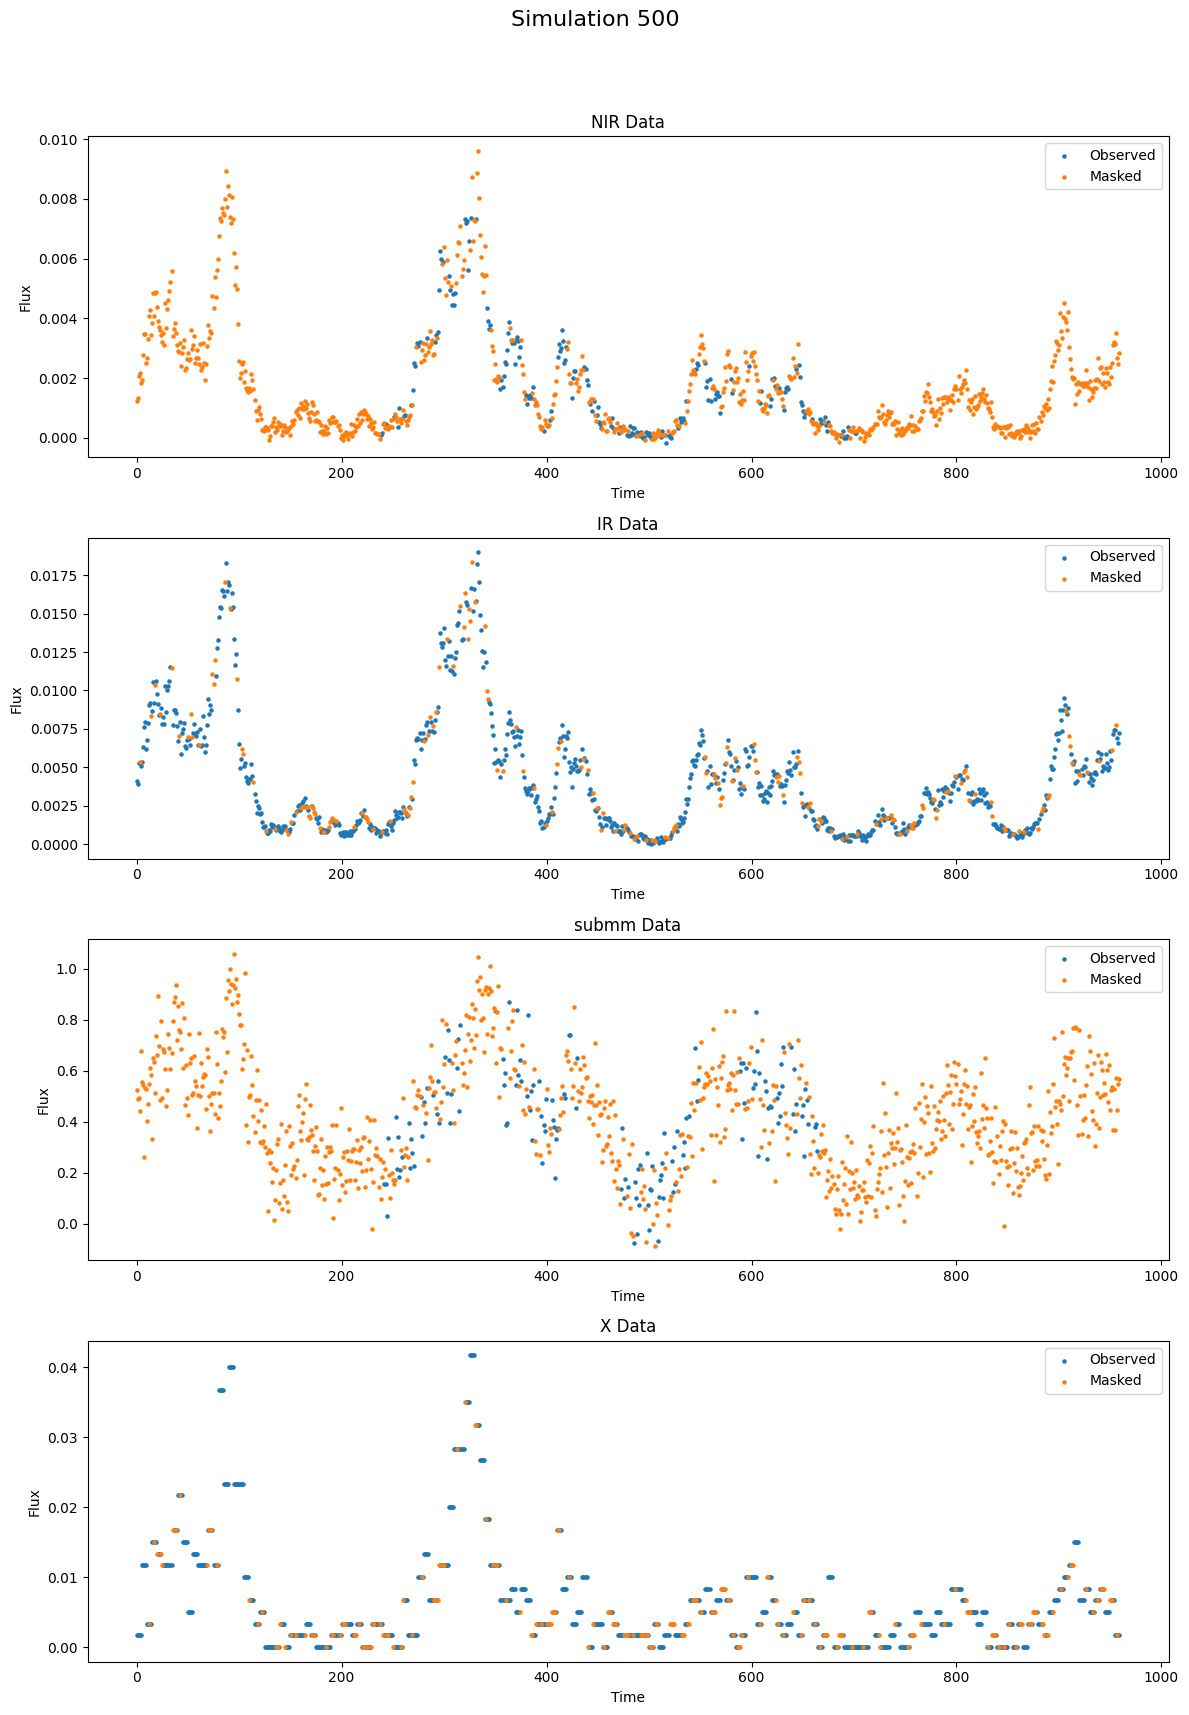

In [2]:
num_simulations = 150
batch_size = 50
num_batches = num_simulations // batch_size + (1 if num_simulations % batch_size != 0 else 0)

all_data = sim.Simulation.load_all_data(num_batches, 4)
print(len(all_data))
# len(all_data)
sim_number = 500
sim.Simulation.plot_simulation(all_data[sim_number]['data'], sim_number, 1)
# simulation.Simulation.plot_all_simulations(all_data)